**Import Essential Libraries**

In [102]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog, local_binary_pattern
import os
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

**Download dataset with different emotions**

In [103]:
# 🔹 Download and unzip your small test dataset
!rm -rf test_data test.zip
!wget -q "https://github.com/Sajjan-Sam/test/raw/main/test.zip" -O test.zip
!unzip -q test.zip -d test_data

Found images: 1575


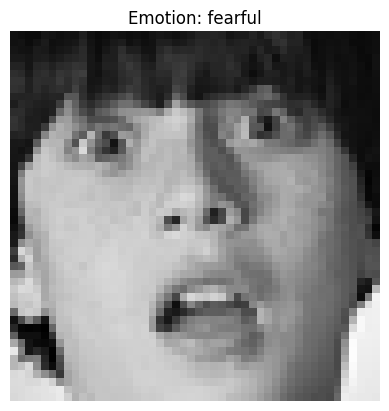

In [104]:
# 🔹 Display one random image from the folders
import cv2, glob, matplotlib.pyplot as plt, random, os

images = glob.glob("test_data/**/*.*", recursive=True)
print("Found images:", len(images))

if images:
    img_path = random.choice(images)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    label = os.path.basename(os.path.dirname(img_path))
    plt.imshow(img)
    plt.title(f"Emotion: {label}")
    plt.axis("off")
    plt.show()



**Understand Feature Extraction - The Problem**

In [105]:
import cv2, os

data_path = "test_data/test"

# pick only valid folders (ignore .git or hidden files)
folders = [f for f in os.listdir(data_path) if not f.startswith('.') and os.path.isdir(os.path.join(data_path, f))]

# pick first emotion and first image
emotion = folders[0]
img_folder = os.path.join(data_path, emotion)
img_file = os.listdir(img_folder)[0]
img_path = os.path.join(img_folder, img_file)

# read and show info
sample_img = cv2.imread(img_path, 0)
print(f"Emotion: {emotion}")
print(f"Image shape: {sample_img.shape}")
print(f"Total pixels: {sample_img.shape[0]} × {sample_img.shape[1]} = {sample_img.shape[0]*sample_img.shape[1]} features")

print("\nToo many features, So Need Feature Extraction (HoG/LBP)")


Emotion: disgusted
Image shape: (48, 48)
Total pixels: 48 × 48 = 2304 features

Too many features, So Need Feature Extraction (HoG/LBP)


**Feature Extraction - Histogram of Oriented Gradients (HoG)**

In [106]:
# Resize to standard size first
standard_size = (64, 64)
sample_img_resized = cv2.resize(sample_img, standard_size)

# Extract HoG features
hog_features = hog(sample_img_resized, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=False)

print(f"Original image: {standard_size[0]}×{standard_size[1]} = {standard_size[0]*standard_size[1]} pixels")
print(f"HoG features extracted: {len(hog_features)} numbers")
print(f"Reduction: {standard_size[0]*standard_size[1]} → {len(hog_features)} (much better!)")
print(f"\nHoG captures: Edge directions (up↑, down↓, left←, right→)")

Original image: 64×64 = 4096 pixels
HoG features extracted: 1764 numbers
Reduction: 4096 → 1764 (much better!)

HoG captures: Edge directions (up↑, down↓, left←, right→)


**Visualize HOG Features**

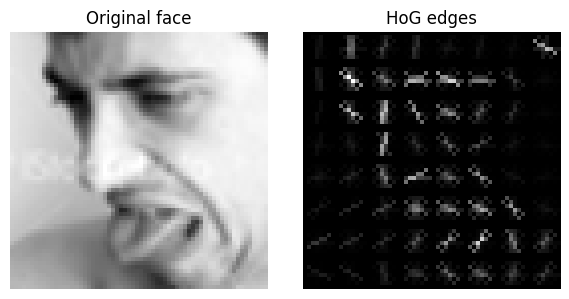

In [107]:
from skimage.feature import hog
import matplotlib.pyplot as plt

# Re-compute HOG but ask for the visualisation image
hog_feats, hog_img = hog(
    sample_img_resized,
    orientations=9,
    pixels_per_cell=(8, 8),
    cells_per_block=(2, 2),
    visualize=True
)

plt.figure(figsize=(6,3))

plt.subplot(1,2,1)
plt.imshow(sample_img_resized, cmap="gray")
plt.title("Original face")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(hog_img, cmap="gray")
plt.title("HoG edges")
plt.axis("off")

plt.tight_layout()
plt.show()


**Feature Extraction - Local Binary Pattern (LBP)**

In [108]:
from skimage.feature import local_binary_pattern
import numpy as np

# Extract LBP features
lbp = local_binary_pattern(sample_img_resized, P=8, R=1, method='uniform')
lbp_hist = np.histogram(lbp, bins=59, range=(0, 59))[0]

print(f"LBP features: {len(lbp_hist)} numbers")
print("HoG & LBP = edges + texture, that will results in better emotion understanding")


LBP features: 59 numbers
HoG & LBP = edges + texture, that will results in better emotion understanding


**Visualize LBP Features**

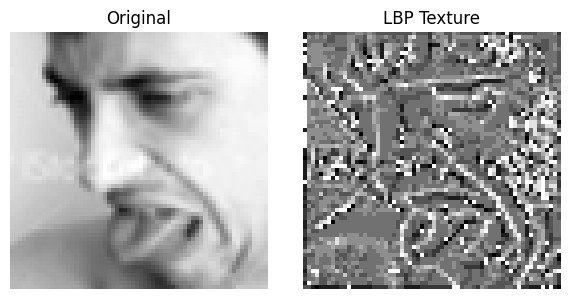

In [109]:
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt

# compute LBP pattern
lbp = local_binary_pattern(sample_img_resized, P=8, R=1, method='uniform')

# show both images
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plt.imshow(sample_img_resized, cmap='gray')
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(lbp, cmap='gray')
plt.title("LBP Texture")
plt.axis("off")
plt.tight_layout()
plt.show()


**Build Feature Extraction Function**

In [110]:
def extract_features(image_path, size=(64, 64)):
    """Extract HoG & LBP from image"""
    img = cv2.imread(image_path, 0)
    if img is None:
        return None
    img = cv2.resize(img, size)

    hog_feat = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2))
    lbp_feat = local_binary_pattern(img, P=8, R=1, method='uniform')
    lbp_hist = np.histogram(lbp_feat, bins=59, range=(0, 59))[0]

    return np.hstack([hog_feat, lbp_hist])

**Load ALL Images and Extract Features**

In [111]:
import os, numpy as np
X, y = [], []
data_path = "test_data/test"

for i, emotion in enumerate(sorted(os.listdir(data_path))):
    for img in os.listdir(f"{data_path}/{emotion}"):
        feat = extract_features(f"{data_path}/{emotion}/{img}")
        if feat is not None: X.append(feat); y.append(i)

X, y = np.array(X), np.array(y)
print("Images:", len(X), "| Features per image:", X.shape[1])


Images: 1575 | Features per image: 1823


**Prepare Data - Split into Training & Testing**

In [112]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set: {X_train.shape[0]} images ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Testing set: {X_test.shape[0]} images ({X_test.shape[0]/len(X)*100:.1f}%)")


Training set: 1260 images (80.0%)
Testing set: 315 images (20.0%)


**Normalize Data (Prepare for SVM)**

In [113]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data normalized (scaled to 0-1 range)")
print(f"Before scaling: min={X_train.min():.0f}, max={X_train.max():.0f}")
print(f"After scaling: min={X_train_scaled.min():.2f}, max={X_train_scaled.max():.2f}")


Data normalized (scaled to 0-1 range)
Before scaling: min=0, max=4096
After scaling: min=-9.65, max=18.57


**Train SVM (Support Vector Machine)**

In [114]:
svm_model = SVC(kernel='rbf', gamma='scale', probability=True)
svm_model.fit(X_train_scaled, y_train)
svm_acc = svm_model.score(X_test_scaled, y_test)

print(f"SVM Accuracy: {svm_acc*100:.2f}%")
print(f"\nWhat SVM does: Finds best line separating emotions in feature space")

SVM Accuracy: 44.13%

What SVM does: Finds best line separating emotions in feature space


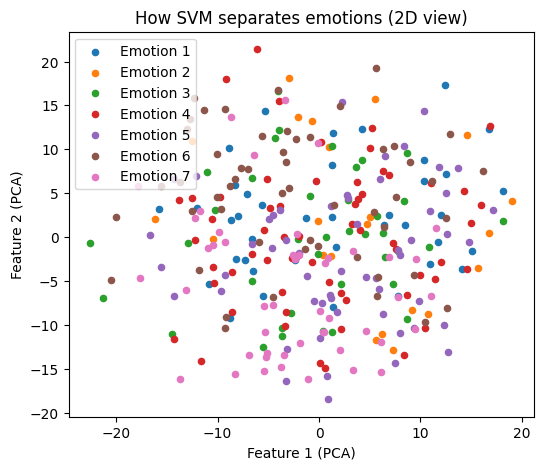

In [115]:
#We’ve turned all those thousands of image features into just two dimensions so we can see them.
#Each dot is an image — colors show different emotions.
#The SVM tries to draw invisible lines to separate these emotion groups
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# reduce features to 2D for visualization
pca = PCA(n_components=2)
X_vis = pca.fit_transform(X_test_scaled)

plt.figure(figsize=(6,5))
for i in np.unique(y_test):
    plt.scatter(X_vis[y_test==i,0], X_vis[y_test==i,1], label=f"Emotion {i}", s=20)

plt.title("How SVM separates emotions (2D view)")
plt.xlabel("Feature 1 (PCA)")
plt.ylabel("Feature 2 (PCA)")
plt.legend()
plt.show()


**Train Decision Tree**

In [116]:
dt_model = DecisionTreeClassifier(max_depth=15, random_state=42)
dt_model.fit(X_train, y_train)
dt_acc = dt_model.score(X_test, y_test)

print(f"Decision Tree Accuracy: {dt_acc*100:.2f}%")
print(f"\nWhat DT does: Makes yes/no decisions like a flowchart")

Decision Tree Accuracy: 22.86%

What DT does: Makes yes/no decisions like a flowchart


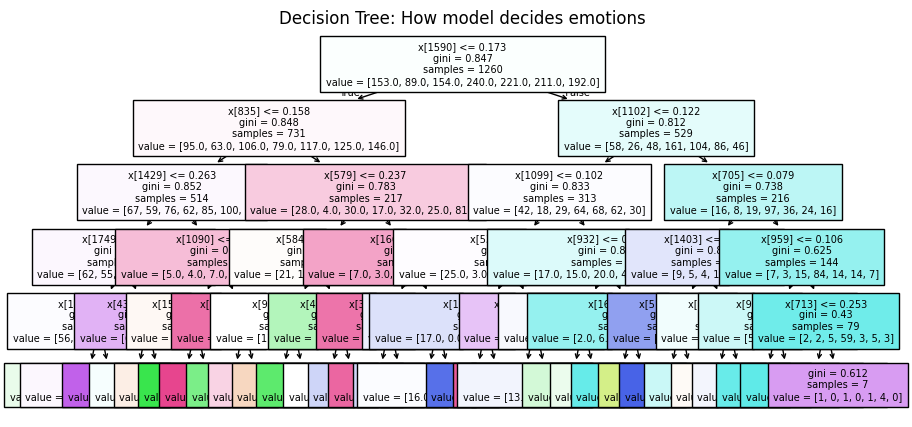

In [117]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# train decision tree again (simple and short)
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)

# visualize
plt.figure(figsize=(10,5))
plot_tree(dt_model, filled=True, fontsize=7)
plt.title("Decision Tree: How model decides emotions")
plt.show()


**Train Random Forest**

In [118]:
rf_model = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
rf_model.fit(X_train, y_train)
rf_acc = rf_model.score(X_test, y_test)

print(f"Random Forest Accuracy: {rf_acc*100:.2f}%")
print(f"\nWhat RF does: 100 decision trees vote on emotion")

Random Forest Accuracy: 36.51%

What RF does: 100 decision trees vote on emotion


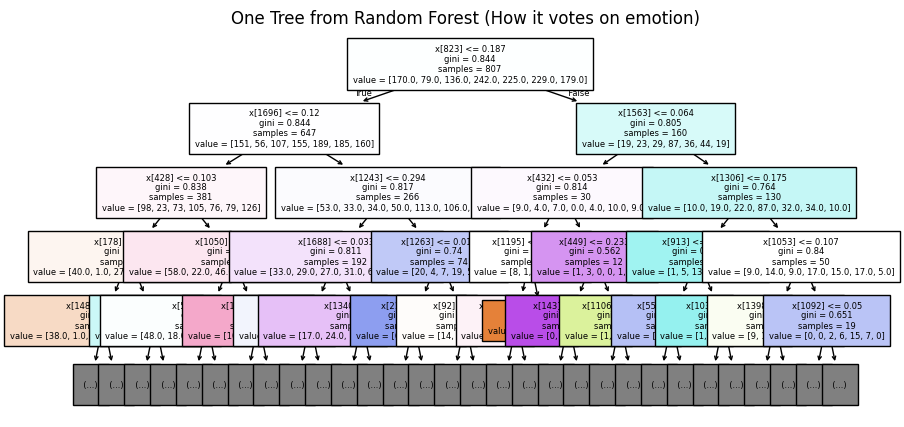

In [119]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# train a small random forest
rf_model = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# show one of its trees
plt.figure(figsize=(10,5))
plot_tree(rf_model.estimators_[0], max_depth=4, filled=True, fontsize=6)
plt.title("One Tree from Random Forest (How it votes on emotion)")
plt.show()


**Train K-Nearest Neighbors**

In [120]:
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)
knn_acc = knn_model.score(X_test_scaled, y_test)

print(f"KNN Accuracy: {knn_acc*100:.2f}%")
print(f"\nWhat KNN does: Finds 5 most similar images and copies their emotion")

KNN Accuracy: 32.70%

What KNN does: Finds 5 most similar images and copies their emotion


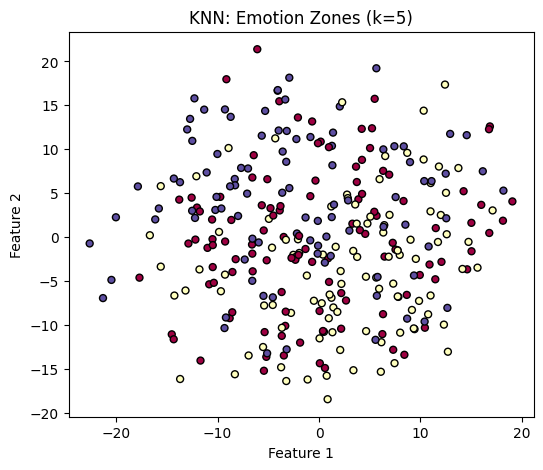

In [121]:
# plot
plt.figure(figsize=(6,5))
plt.scatter(X2[:,0], X2[:,1], c=y_pred, cmap='Spectral', s=25, edgecolor='k')
plt.title("KNN: Emotion Zones (k=5)")
plt.xlabel("Feature 1"); plt.ylabel("Feature 2")
plt.show()


**Compare All Models - Bar Chart**

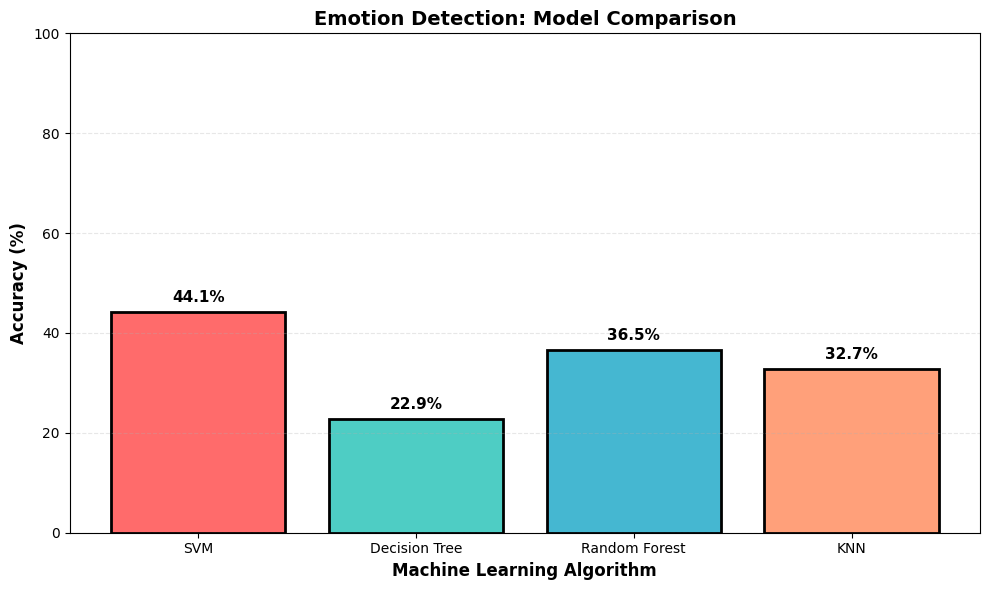


 Best Model: SVM
   Accuracy: 44.13%


In [122]:
models_results = {
    'SVM': svm_acc,
    'Decision Tree': dt_acc,
    'Random Forest': rf_acc,
    'KNN': knn_acc
}

plt.figure(figsize=(10, 6))
models = list(models_results.keys())
accuracies = [v*100 for v in models_results.values()]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
bars = plt.bar(models, accuracies, color=colors, edgecolor='black', linewidth=2)

plt.ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
plt.xlabel('Machine Learning Algorithm', fontsize=12, fontweight='bold')
plt.title('Emotion Detection: Model Comparison', fontsize=14, fontweight='bold')
plt.ylim([0, 100])

for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    plt.text(i, acc + 2, f'{acc:.1f}%', ha='center', fontweight='bold', fontsize=11)

plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print(f"\n Best Model: {max(models_results, key=models_results.get)}")
print(f"   Accuracy: {max(models_results.values())*100:.2f}%")

**Confusion Matrix - What Gets Wrong?**

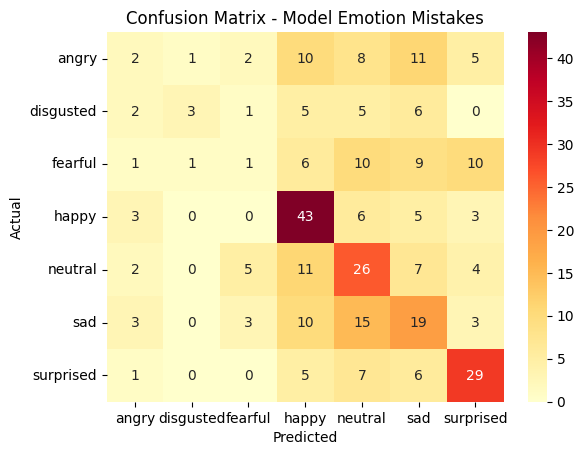

In [123]:
from sklearn.metrics import confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt, os

# get emotion names from folders
emotion_names = sorted([f for f in os.listdir("test_data/test") if not f.startswith('.')])

y_pred = rf_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='YlOrRd',
            xticklabels=emotion_names, yticklabels=emotion_names)
plt.title("Confusion Matrix - Model Emotion Mistakes")
plt.xlabel("Predicted"); plt.ylabel("Actual")
plt.show()


**Classification Report - Detailed Metrics**

In [127]:

from sklearn.metrics import classification_report
import os

emotion_names = sorted([f for f in os.listdir("test_data/test") if not f.startswith('.')])

print("DETAILED PERFORMANCE METRICS\n")
report = classification_report(y_test, y_pred, target_names=emotion_names, digits=3)
print(report)

print("\nPrecision → When model says 'Happy', is it right? (True Positives)")
print("Recall → Does model find all 'Happy' faces? (Avoids False Negatives)")
print("F1-Score → Balance between Precision & Recall")


DETAILED PERFORMANCE METRICS

              precision    recall  f1-score   support

       angry      0.143     0.051     0.075        39
   disgusted      0.600     0.136     0.222        22
     fearful      0.083     0.026     0.040        38
       happy      0.478     0.717     0.573        60
     neutral      0.338     0.473     0.394        55
         sad      0.302     0.358     0.328        53
   surprised      0.537     0.604     0.569        48

    accuracy                          0.390       315
   macro avg      0.354     0.338     0.314       315
weighted avg      0.352     0.390     0.349       315


Precision → When model says 'Happy', is it right? (True Positives)
Recall → Does model find all 'Happy' faces? (Avoids False Negatives)
F1-Score → Balance between Precision & Recall
